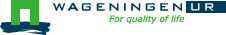



# Optimizing parameters in a PCSE crop model

## 필요한 패키지 불러오기

In [1]:
%matplotlib inline
import sys
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
import yaml
import pandas as pd
import numpy as np
import nlopt
from itertools import product

import pcse
from pcse.models import Wofost72_PP
from pcse.base import ParameterProvider
from pcse.db import NASAPowerWeatherDataProvider
from pcse.fileinput import YAMLAgroManagementReader, YAMLCropDataProvider
from pcse.util import WOFOST72SiteDataProvider, DummySoilDataProvider
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0] 
PCSE version: 5.5.0


## WOFOST에 필요한 입력 데이터 불러오기

In [2]:
# Weather data for Netherlands
wdp = NASAPowerWeatherDataProvider(latitude=52, longitude=5)
# Standard crop parameter library
cropd = YAMLCropDataProvider()
# We don't need soil for potential production, so we use dummy values
soild = DummySoilDataProvider()
# Some site parameters
sited = WOFOST72SiteDataProvider(WAV=50, CO2=360.)
# Package everyting into a single parameter object
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)

In [3]:
# Here we define the agromanagement for sugar beet
agro_yaml = """
- 2006-01-01:
    CropCalendar:
        crop_name: sugarbeet
        variety_name: Sugarbeet_603
        crop_start_date: 2006-03-31
        crop_start_type: emergence
        crop_end_date: 2006-10-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents: null
"""
agro = yaml.load(agro_yaml, Loader=yaml.FullLoader)

# 기본값으로 시뮬레이션 작동
예시 관측값으로 활용하기 위해 WOFOST의 기본 출력값을 사용하고자 하며, 기본 파라미터 및 출력값을 불러오기 위해 먼저 시뮬레이션을 작동해야 합니다.

In [4]:
wofost = Wofost72_PP(params, wdp, agro)
wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output())
df.index = pd.to_datetime(df.day)
df.tail()

,day,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,,
2006-10-16,2006-10-16,2.182200,1.318570,25045.166727,14916.025792,5112.997882,5016.143053,3982.758431,0.082313,120.0,0.3,None
2006-10-17,2006-10-17,2.187357,1.327063,25130.092963,14992.459404,5117.244194,5020.389365,3984.491619,0.078241,120.0,0.3,None
2006-10-18,2006-10-18,2.193236,1.335364,25213.103257,15067.168669,5121.394709,5024.539880,3986.185707,0.051568,120.0,0.3,None
2006-10-19,2006-10-19,2.200414,1.312543,25242.014171,15093.188491,5122.840255,5025.985425,3986.775725,0.046447,120.0,0.3,None
2006-10-20,2006-10-20,2.207914,1.315999,25276.576594,15124.294672,5124.568376,5027.713546,3987.481081,0.067994,120.0,0.3,None


## "관측값" 생성을 위한 WOFOST 출력 샘플링
원본 데이터는 하루 간격입니다. <br>
일주일 간격으로 수집한 LAI 데이터가 있다고 가정하여 WOFOST 출력값을 resample합니다.

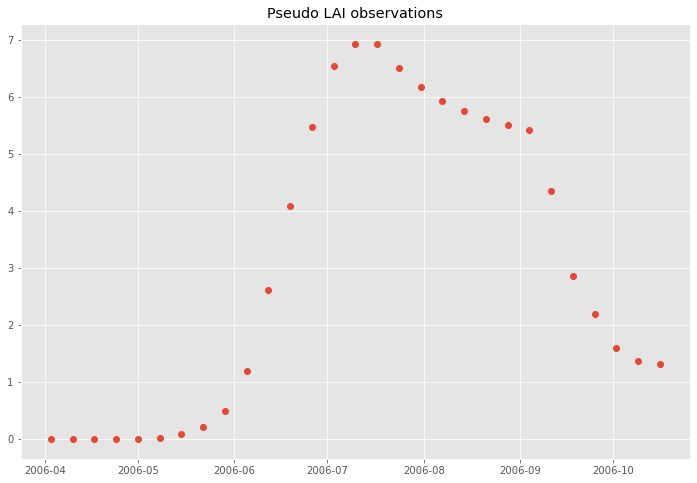

In [5]:
# get daily observations for those
ix = (df.index.dayofweek == 0) & (df.LAI.notnull())
df_pseudo_obs = df.loc[ix]
fig, axes = plt.subplots(figsize=(12,8))
axes.plot_date(df_pseudo_obs.index, df_pseudo_obs.LAI)
r = axes.set_title("Pseudo LAI observations")

## 모델 작동 모듈 정의
WOFOST 모델을 다른 파라미터로 재작동하는 모듈(class)을 정의합니다. <br>
이 튜토리얼에서는 수집한 "LAI"에 대해 "TDWI"와 "SPAN"을 최적화하는 상황을 가정합니다.

`ModelRerunner`는 작동한 모델의 출력을 수집하고 pandas 데이터프레임으로 변환하여 반환합니다. <br>
`ModelRerunner`는 `ParameterProvider`의 `set_override()` 함수를 사용하여 새로운 파라미터로 변경합니다.

In [6]:
class ModelRerunner(object):
    """Reruns a given model with different values of parameters TWDI and SPAN.
    
    Returns a pandas DataFrame with simulation results of the model with given
    parameter values.
    """
    parameters = ["TDWI", "SPAN"]
    
    def __init__(self, params, wdp, agro):
        self.params = params
        self.wdp = wdp
        self.agro = agro
        
    def __call__(self, par_values):
        # Check if correct number of parameter values were provided
        if len(par_values) != len(self.parameters):
            msg = "Optimizing %i parameters, but only % values were provided!" % (len(self.parameters, len(par_values)))
            raise RuntimeError(msg)
        # Clear any existing overrides
        self.params.clear_override()
        # Set overrides for the new parameter values
        for parname, value in zip(self.parameters, par_values):
            self.params.set_override(parname, value)
        # Run the model with given parameter values
        wofost = Wofost72_PP(self.params, self.wdp, self.agro)
        wofost.run_till_terminate()
        df = pd.DataFrame(wofost.get_output())
        df.index = pd.to_datetime(df.day)
        return df

## 목적함수(error) 계산 모듈 정의
`ObjectiveFunctionCalculator`는 주어진 파라미터에 대해 `ModelRerunner`를 불러와 WOFOST 모델을 작동하고, 시뮬레이션 결과를 이용해 관측값과의 차이를 구합니다. <br>
이 튜토리얼에서 목적함수는 최소제곱근오차(Root mean squared error, RMSE)입니다.

In [7]:
class ObjectiveFunctionCalculator(object):
    """Computes the objective function.
    
    This class runs the simulation model with given parameter values and returns the objective
    function as the sum of squared difference between observed and simulated LAI.
.   """
    
    def __init__(self, params, wdp, agro, observations):
        self.modelrerunner = ModelRerunner(params, wdp, agro)
        self.df_observations = observations
        self.n_calls = 0
       
    def __call__(self, par_values, grad=None):
        """Runs the model and computes the objective function for given par_values.
        
        The input parameter 'grad' must be defined in the function call, but is only
        required for optimization methods where analytical gradients can be computed.
        """
        self.n_calls += 1
        print(".", end="")
        # Run the model and collect output
        self.df_simulations = self.modelrerunner(par_values)
        # compute the differences by subtracting the DataFrames
        # Note that the dataframes automatically join on the index (dates) and column names
        df_differences = self.df_simulations - self.df_observations
        # Compute the RMSE on the LAI column
        obj_func = np.sqrt(np.mean(df_differences.LAI**2))
        return obj_func

In [8]:
# 목적 함수 계산 모듈 테스트
objfunc_calculator = ObjectiveFunctionCalculator(params, wdp, agro, df_pseudo_obs)
defaults = [cropd["TDWI"], cropd["SPAN"]]
error = objfunc_calculator(defaults)
print("Objective function value with default parameters (%s): %s" % (defaults, error))

.Objective function value with default parameters ([0.51, 37.0]): 0.0


## 무차별 대입으로 최적화하기
최적화 방법에 앞서 TDWI와 SPAM을 그리드로 만들어서 무차별 대입해봅니다(grid search). <br>
step size만큼 간격을 둔 그리드에서 TDWI와 SPAN을 변화시키며 대입하는 코드를 구현하였으며, 물론 step size가 줄어들수록 더 정확한 값을 찾을 수 있습니다. <br>
다만, step size 증가나 parameter 개수 증가에 따라 계산 시간이 지수적으로 증가하므로 다소 비현실적입니다. <br>

step size가 충분히 작지 않기 때문에 error를 0으로 만들지는 않겠습니다.

In [9]:
lowest_error = 99999
best_values = None

# min/max and values for TDWI
TDWI_range = [0.1, 0.6]
stepsize1 = 0.1
TDWI_values = np.arange(TDWI_range[0], TDWI_range[1], stepsize1)

# min/max and values for SPAN
SPAN_range = [30, 40]
stepsize2 = 5
SPAN_values = np.arange(SPAN_range[0], SPAN_range[1], stepsize2)

nruns = len(TDWI_values) * len(SPAN_values)
ncalls = 0
for p1, p2 in product(TDWI_values, SPAN_values):
    ncalls += 1
    error = objfunc_calculator([p1, p2])
    if error <  lowest_error:
        best_values = [p1, p2]
        lowest_error = error

print("\noptimum at TDWI: %s, SPAN: %s" % (best_values[0], best_values[1]))
print("minimum value = ",  lowest_error)
print("With %i function calls" % ncalls)

..........
optimum at TDWI: 0.5, SPAN: 35
minimum value =  0.27891968442605414
With 10 function calls


## 더 나은 최적화 방법: NLOPT

NLOPT를 사용하면 더 빠르게 더 나은 최적점에 도달할 수 있습니다.

In [10]:
objfunc_calculator = ObjectiveFunctionCalculator(params, wdp, agro, df_pseudo_obs)
# Start optimizer with the SUBPLEX algorithm for two parameters
opt = nlopt.opt(nlopt.LN_SBPLX, 2)
# Assign the objective function calculator
opt.set_min_objective(objfunc_calculator)
# lower bounds of parameters values
opt.set_lower_bounds([TDWI_range[0], SPAN_range[0]])
# upper bounds of parameters values
opt.set_upper_bounds([TDWI_range[1], SPAN_range[1]])
# the initial step size to compute numerical gradients
opt.set_initial_step([0.02, 2.])
# Maximum number of evaluations allowed
opt.set_maxeval(100)
# Relative tolerance for convergence
opt.set_ftol_rel(0.1)

# Start the optimization with the first guess
firstguess = [0.2, 31.]
x = opt.optimize(firstguess)
print("\noptimum at TDWI: %s, SPAN: %s" % (x[0], x[1]))
print("minimum value = ",  opt.last_optimum_value())
print("result code = ", opt.last_optimize_result())
print("With %i function calls" % objfunc_calculator.n_calls)

.................................................
optimum at TDWI: 0.4016699218750006, SPAN: 37.01171875
minimum value =  0.14530121318162467
result code =  3
With 49 function calls


## 결과 그래프

..

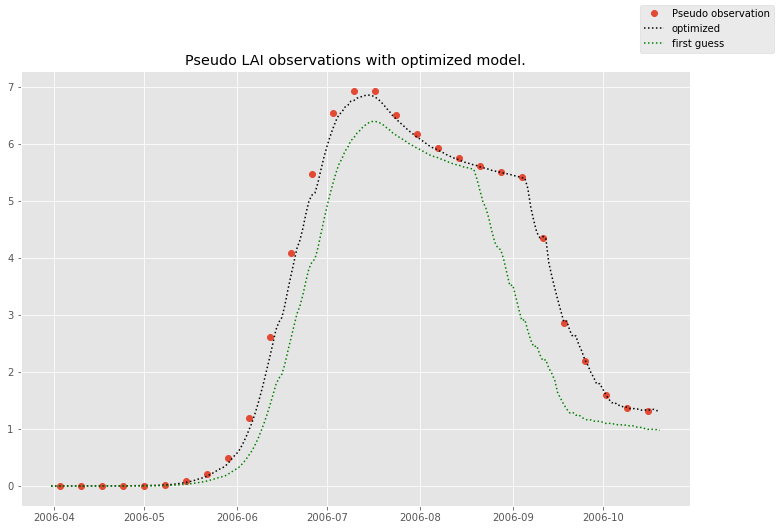

In [11]:
# rerun with the best parameters found
error = objfunc_calculator(x)
fig, axes = plt.subplots(figsize=(12,8))
axes.plot_date(df_pseudo_obs.index, df_pseudo_obs.LAI, label="Pseudo observation")
axes.plot_date(objfunc_calculator.df_simulations.index, objfunc_calculator.df_simulations.LAI, "k:", label="optimized")
# rerun to show the first guess for the first guess
error = objfunc_calculator(firstguess)
axes.plot_date(objfunc_calculator.df_simulations.index, objfunc_calculator.df_simulations.LAI, "g:", label="first guess")
axes.set_title("Pseudo LAI observations with optimized model.")
r = fig.legend()

..

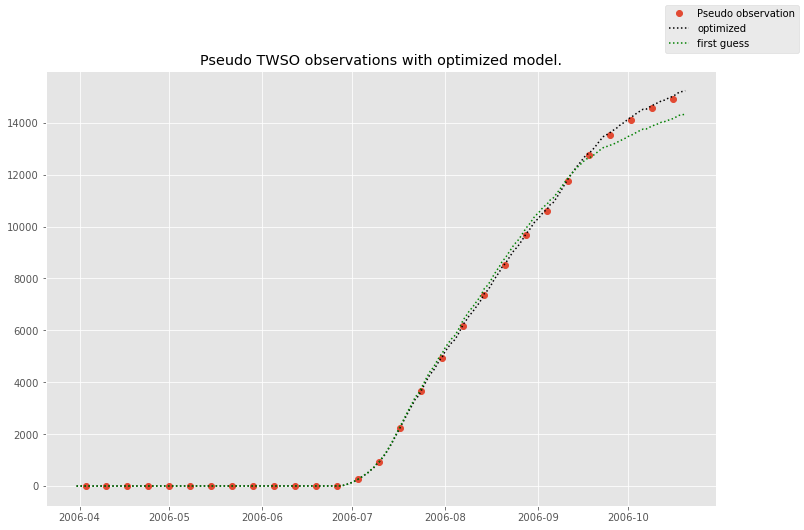

In [12]:
# rerun with the best parameters found
error = objfunc_calculator(x)
fig, axes = plt.subplots(figsize=(12,8))
axes.plot_date(df_pseudo_obs.index, df_pseudo_obs.TWSO, label="Pseudo observation")
axes.plot_date(objfunc_calculator.df_simulations.index, objfunc_calculator.df_simulations.TWSO, "k:", label="optimized")
# rerun to show the first guess for the first guess
error = objfunc_calculator(firstguess)
axes.plot_date(objfunc_calculator.df_simulations.index, objfunc_calculator.df_simulations.TWSO, "g:", label="first guess")
axes.set_title("Pseudo TWSO observations with optimized model.")
r = fig.legend()

같은 작물에 대한 데이터이므로, LAI 기준으로만 맞추어도 다른 생육 지표 역시 잘 맞는 것을 알 수 있습니다.